## Part 1: solve the differential equation 

In [203]:
from scipy.fftpack import fft, ifft
import numpy as np
import math
import scipy.integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as io

In [204]:
L = 30
n = 256
x2 = np.linspace(-L/2, L/2, n+1)
x = x2[0:n]
k_array = np.append(np.array(range(n//2)), np.array(range(-n//2, 0)))
k = (2*math.pi / L) * (k_array.transpose())
t = np.linspace(0, 2*math.pi, 101)
u = 2*(1/np.cosh(x))
ut = fft(u,axis=0)

In [205]:
def nls_rhs(t, ut):
    u = ifft(ut.transpose(), axis=0)
    L = 30
    n = 256
    k_array = np.append(np.array(range(n//2)), np.array(range(-n//2, 0)))
    k = (2*math.pi / L) * (k_array.transpose())
    rhs = -(1j/2) * (k**2) * ut + 1j * (fft(abs(u)**2 * u).transpose())
    return rhs

In [206]:
solver = scipy.integrate.solve_ivp(nls_rhs, t_span=[0, 2*math.pi], y0=ut, t_eval=t)

In [207]:
utsol = solver.y
utsol = utsol.transpose()

In [208]:
usol = np.zeros([101,256],dtype=np.complex_)

In [209]:
for j in range(len(t)):
    usol[j,:] = ifft(utsol[j,:])

<IPython.core.display.Javascript object>


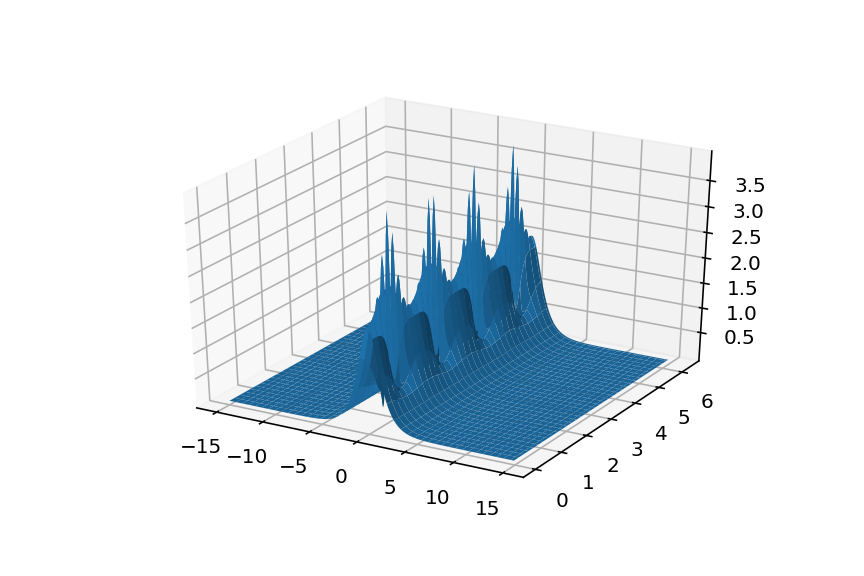

In [233]:
t = t.reshape(101,1)
%matplotlib notebook
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax.plot_surface(X=x, Y=t, Z=abs(usol))
plt.show()

In [211]:
# error: (difference from the matlab result)
usol_real = io.loadmat('/Users/Lee/HPC/usol.mat')
print('Single Max Difference: {} \n'.format(np.max(abs(usol_real['usol'] - usol))),
     'Total Difference: {}'.format(np.sum(abs(usol_real['usol'] - usol))))

Single Max Difference: 0.0007405319860922554 
 Total Difference: 3.9515129818251005


### Summary 1:

We have slightly different result from the matlab result:
Because of python's lack of direct 'sech' function, we use '1/cosh' instead
and fft in python includes all the imaginary parts (matlab ignores some of the insignificant ones).


## Part 2: Build Reduced Order Model (with SVD) to capture the major variance of Part 1's structure

In [212]:
matlab_usol = io.loadmat('/Users/Lee/HPC/usol.mat')
matlab_us = io.loadmat('/Users/Lee/HPC/us.mat')

In [213]:
X = usol.transpose()

In [214]:
# X = matlab_usol['usol'].transpose()

In [215]:
[u,s,v] = np.linalg.svd(X)

In [216]:
%matplotlib inline

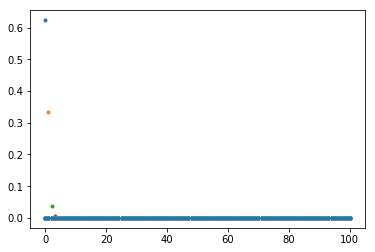

In [217]:
plt.plot(np.diag(s)/np.sum(np.diag(s)),'.')
plt.show() 

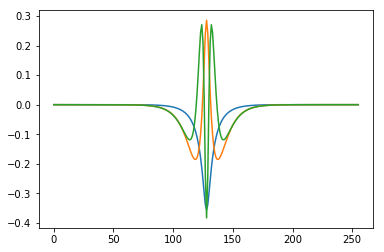

In [218]:
plt.plot(np.real(u[:,0:3]))
plt.show()

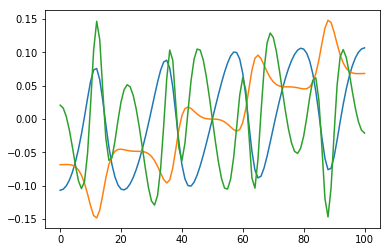

In [219]:
plt.plot(np.real(v.transpose()[:,0:3]))
plt.show()

In [220]:
r = 3 
phi = u[:,0:r]

In [221]:
phixx = np.zeros([256,3],dtype=np.complex_)
a0 = np.zeros([1,3],dtype=np.complex_)

In [222]:
for j in range(r):
    phixx[:,j] = (-1) * ifft((k**2) * fft(phi[:,j]))
    a0[0,j] = np.matmul(2*(1/np.cosh(x)), (phi[:,j].conj()))

In [223]:
Lr = np.matmul((1j/2) * phi.transpose(), phixx)

In [224]:
P = np.identity(n)
PNL = np.matmul(P,phi)

In [225]:
def a_rhs(t, a):
    rhs = np.matmul(Lr,a) + 1j * np.matmul((PNL.conj().transpose()), ((abs(np.matmul(PNL, a)) ** 2) * np.matmul(PNL, a)))
    return rhs

In [226]:
solver2 = scipy.integrate.solve_ivp(a_rhs, t_span=[0, 2*math.pi], y0=a0.reshape(3), t_eval=t.reshape(101))

In [227]:
us = np.zeros([n,len(t)],dtype=np.complex_)
asol = solver2.y
t = solver2.t

In [228]:
asol = asol.transpose()

In [229]:
for j in range(len(t)):
    for jj in range(r):
        temp = asol[j,jj] * phi[:,jj]
        us[:,j] = us[:,j] + temp

In [230]:
us = us.transpose()

<IPython.core.display.Javascript object>


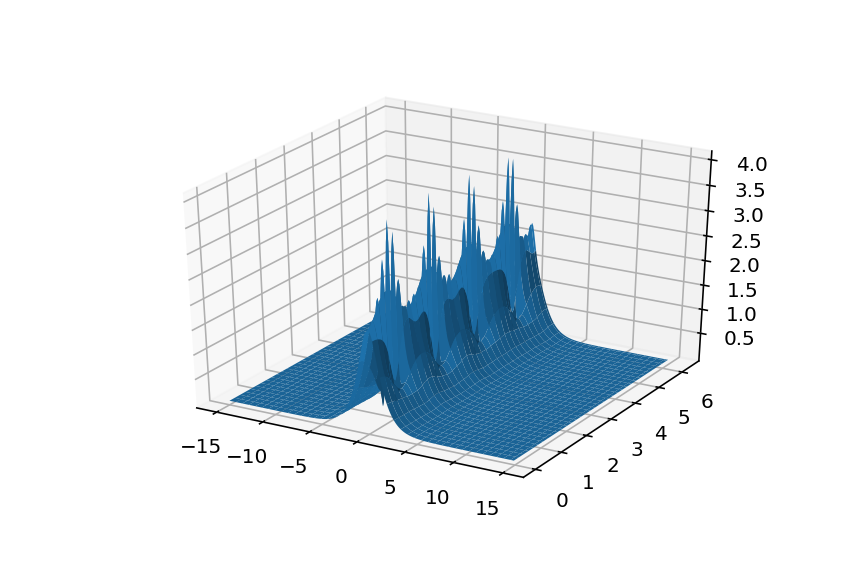

In [234]:
t = t.reshape(101,1)
%matplotlib notebook
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax.plot_surface(X=x, Y=t, Z=abs(us))
plt.show()

In [232]:
print('Python: Difference between the original solution and the reduced order method: \n {} '.format(np.sum(abs(usol)-abs(us))))
print('Matlab: Difference between the original solution and the reduced order method: \n {} '.format(np.sum(abs(matlab_usol['usol'])-abs(matlab_us['us'].transpose()))))

Python: Difference between the original solution and the reduced order method: 
 5.26295290599016 
Matlab: Difference between the original solution and the reduced order method: 
 7.042225793897807 


### Summary 2:


Compared the difference between the original result and the ROM result in absolute value:

In python, the difference is about 5.26, In matlab, the difference is about 7.04 

Because of the original solution value in Part 1 is slightly different, the svd in python and matlab give different results